# 🎬 Movie Success Prediction and Sentiment Study

**Complete Data Science Pipeline: From Raw Data to Predictive Insights**

---

## Project Overview

This notebook demonstrates a complete data science workflow:
1. **Phase 1**: Data Acquisition & Setup
2. **Phase 2**: Sentiment Analysis with VADER
3. **Phase 3**: Exploratory Data Analysis (EDA)
4. **Phase 4**: Predictive Modeling

**Goal**: Predict movie box office revenue based on sentiment scores, budget, and genre.

## 1. Setup & Import Libraries

In [26]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os

# Add src directory to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.3.2


## 2. Phase 1: Data Acquisition

We'll load our movie dataset with 200+ samples for robust ML training.

In [38]:
# Import our custom modules
from phase1_data_acquisition import create_sample_data, load_data_from_csv, inspect_data

# Generate sample data (or load from CSV)
# Option 1: Generate realistic synthetic data
## df = create_sample_data(n_samples=200)

# Option 2: Load TMDB dataset (recommended)
# Note: this notebook lives in notebooks/, so datasets are usually in ../data/
df = load_data_from_csv('../data/tmdb_5000_movies.csv')

# --- Normalize TMDB columns so the rest of the notebook works ---
import json
import pandas as pd

# Revenue/Budget in millions
if 'Revenue_Millions' not in df.columns and 'revenue' in df.columns:
    df['Revenue_Millions'] = pd.to_numeric(df['revenue'], errors='coerce') / 1_000_000.0
if 'Budget_Millions' not in df.columns and 'budget' in df.columns:
    df['Budget_Millions'] = pd.to_numeric(df['budget'], errors='coerce') / 1_000_000.0

# Genre (extract first genre name from TMDB JSON list)
if 'Genre' not in df.columns and 'genres' in df.columns:
    def _first_genre_name(val):
        if pd.isna(val) or str(val).strip() in ('', '[]'):
            return 'Unknown'
        try:
            arr = json.loads(str(val).replace("'", '"'))
            if isinstance(arr, list) and len(arr) > 0 and isinstance(arr[0], dict):
                return arr[0].get('name', 'Unknown')
        except Exception:
            pass
        # Fallback for other formats
        return str(val).split('|')[0].split(',')[0].strip() or 'Unknown'
    df['Genre'] = df['genres'].apply(_first_genre_name)

# Text column for sentiment (the sentiment module expects User_Review)
if 'User_Review' not in df.columns:
    if 'overview' in df.columns:
        df = df.rename(columns={'overview': 'User_Review'})
    elif 'tagline' in df.columns:
        df = df.rename(columns={'tagline': 'User_Review'})
    else:
        df['User_Review'] = ''

# Movie title consistency (some cells use Movie_Title)
if 'Movie_Title' not in df.columns and 'title' in df.columns:
    df = df.rename(columns={'title': 'Movie_Title'})

print(f"\nDataset loaded: {df.shape[0]} movies, {df.shape[1]} features")
print("Columns now available for notebook:")
print([c for c in ['Movie_Title','User_Review','Genre','Budget_Millions','Revenue_Millions'] if c in df.columns])

[OK] Successfully loaded data from ../data/tmdb_5000_movies.csv
  Shape: 4803 rows, 20 columns

Dataset loaded: 4803 movies, 23 features
Columns now available for notebook:
['Movie_Title', 'User_Review', 'Genre', 'Budget_Millions', 'Revenue_Millions']


In [31]:
# Inspect the data
print("=" * 60)
print("DATA INSPECTION")
print("=" * 60)

print("\n--- First 5 rows ---")
df.head()

DATA INSPECTION

--- First 5 rows ---


,budget,genres,homepage,id,keywords,original_language,original_title,User_Review,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,Movie_Title,vote_average,vote_count,Revenue_Millions,Budget_Millions,Genre
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2787.965087,237.0,Action
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,961.000000,300.0,Adventure
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,880.674609,245.0,Action
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,1084.939099,250.0,Action
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,284.139100,260.0,Action


In [32]:
# Data types and missing values
print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Statistical Summary ---")
df.describe()


--- Data Types ---
budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
User_Review              object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
Movie_Title              object
vote_average            float64
vote_count                int64
Revenue_Millions        float64
Budget_Millions         float64
Genre                    object
dtype: object

--- Missing Values ---
budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
Use

,budget,id,popularity,revenue,runtime,vote_average,vote_count,Revenue_Millions,Budget_Millions
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,82.260639,29.045040
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,162.857101,40.722391
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,0.000000,0.790000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,19.170001,15.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,92.917187,40.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,2787.965087,380.000000



--- Genre Distribution ---
Genre
Drama              1207
Comedy             1042
Action              754
Adventure           339
Horror              300
Crime               195
Thriller            194
Animation           123
Fantasy             117
Romance             106
Science Fiction      96
Documentary          89
Family               56
Mystery              41
Music                34
Unknown              28
Western              27
History              25
War                  24
TV Movie              4
Foreign               2
Name: count, dtype: int64


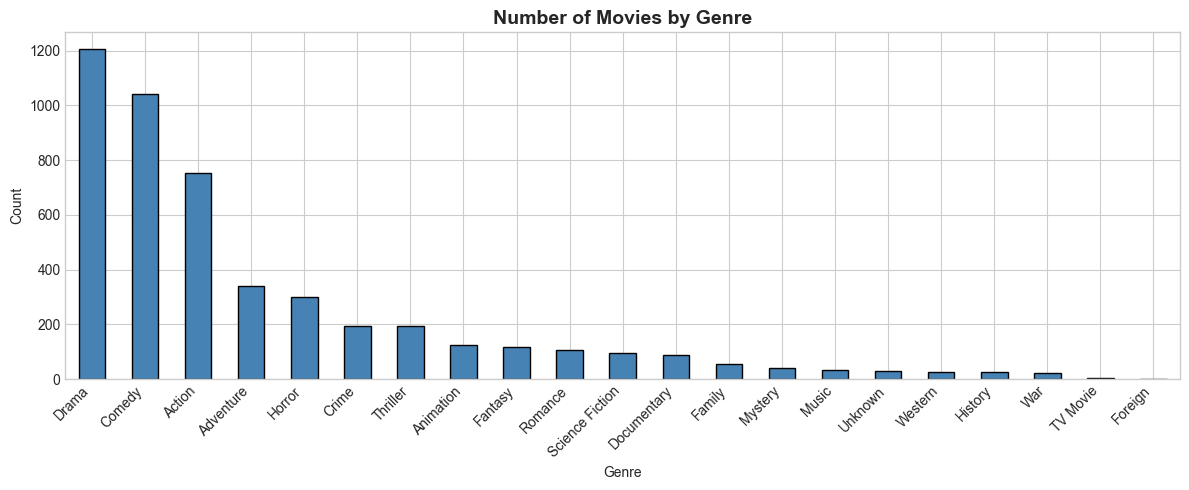

In [33]:
# Genre distribution
print("\n--- Genre Distribution ---")
genre_counts = df['Genre'].value_counts()
print(genre_counts)

plt.figure(figsize=(12, 5))
genre_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Number of Movies by Genre', fontsize=14, fontweight='bold')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Phase 2: Sentiment Analysis with VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is specifically tuned for sentiment analysis of social media and short texts like movie reviews.

In [34]:
from phase2_sentiment_analysis import preprocess_text, analyze_sentiment

# Preprocess the review text
print("Preprocessing text...")
df = preprocess_text(df, review_column='User_Review')

# Apply VADER sentiment analysis
print("\nApplying VADER sentiment analysis...")
df = analyze_sentiment(df, review_column='User_Review', add_detailed=True)

Preprocessing text...

Applying VADER sentiment analysis...
Analyzing sentiment for 4803 reviews...

--- Sentiment Analysis Summary ---
Total reviews analyzed: 4803
Average sentiment: -0.073
Sentiment range: -0.996 to 0.996

Sentiment Distribution:
Sentiment_Category
Very Negative    1672
Negative          796
Neutral           347
Positive          708
Very Positive    1280
Name: count, dtype: int64


In [35]:
# Display sentiment results
print("\n--- Sentiment Analysis Results ---")
df[['Movie_Title', 'User_Review', 'Sentiment_Score', 'Sentiment_Category']].head(10)


--- Sentiment Analysis Results ---


,Movie_Title,User_Review,Sentiment_Score,Sentiment_Category
0,Avatar,"in the 22nd century, a paraplegic marine is di...",-0.3612,Negative
1,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha...",-0.3919,Negative
2,Spectre,a cryptic message from bond’s past sends him o...,-0.8271,Very Negative
3,The Dark Knight Rises,following the death of district attorney harve...,-0.9136,Very Negative
4,John Carter,"john carter is a war-weary, former military ca...",-0.7096,Very Negative
5,Spider-Man 3,the seemingly invincible spider-man goes up ag...,0.5859,Very Positive
6,Tangled,when the kingdom's most wanted-and most charmi...,0.4215,Positive
7,Avengers: Age of Ultron,when tony stark tries to jumpstart a dormant p...,-0.3182,Negative
8,Harry Potter and the Half-Blood Prince,"as harry begins his sixth year at hogwarts, he...",0.0000,Neutral
9,Batman v Superman: Dawn of Justice,fearing the actions of a god-like super hero l...,0.4201,Positive


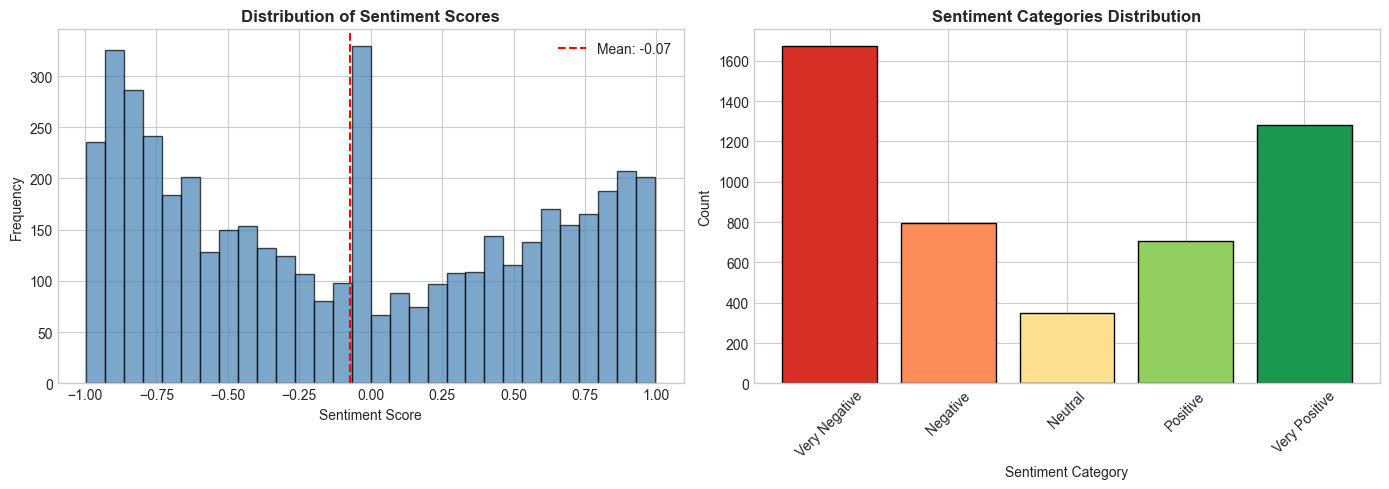

In [36]:
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of sentiment scores
axes[0].hist(df['Sentiment_Score'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['Sentiment_Score'].mean(), color='red', linestyle='--', label=f"Mean: {df['Sentiment_Score'].mean():.2f}")
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sentiment Scores', fontweight='bold')
axes[0].legend()

# Sentiment category counts
category_counts = df['Sentiment_Category'].value_counts().sort_index()
colors = ['#d73027', '#fc8d59', '#fee090', '#91cf60', '#1a9850']
axes[1].bar(category_counts.index.astype(str), category_counts.values, color=colors, edgecolor='black')
axes[1].set_xlabel('Sentiment Category')
axes[1].set_ylabel('Count')
axes[1].set_title('Sentiment Categories Distribution', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Phase 3: Exploratory Data Analysis

Let's explore the relationships between sentiment, budget, genre, and revenue.

In [37]:
# Key question: Is there a relationship between sentiment and revenue?
print("=" * 60)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Correlation matrix
numerical_cols = ['Sentiment_Score', 'Budget_Millions', 'Revenue_Millions', 'Rating']
correlation = df[numerical_cols].corr()

print("\n--- Correlation Matrix ---")
print(correlation.round(3))

EXPLORATORY DATA ANALYSIS


KeyError: "['Rating'] not in index"

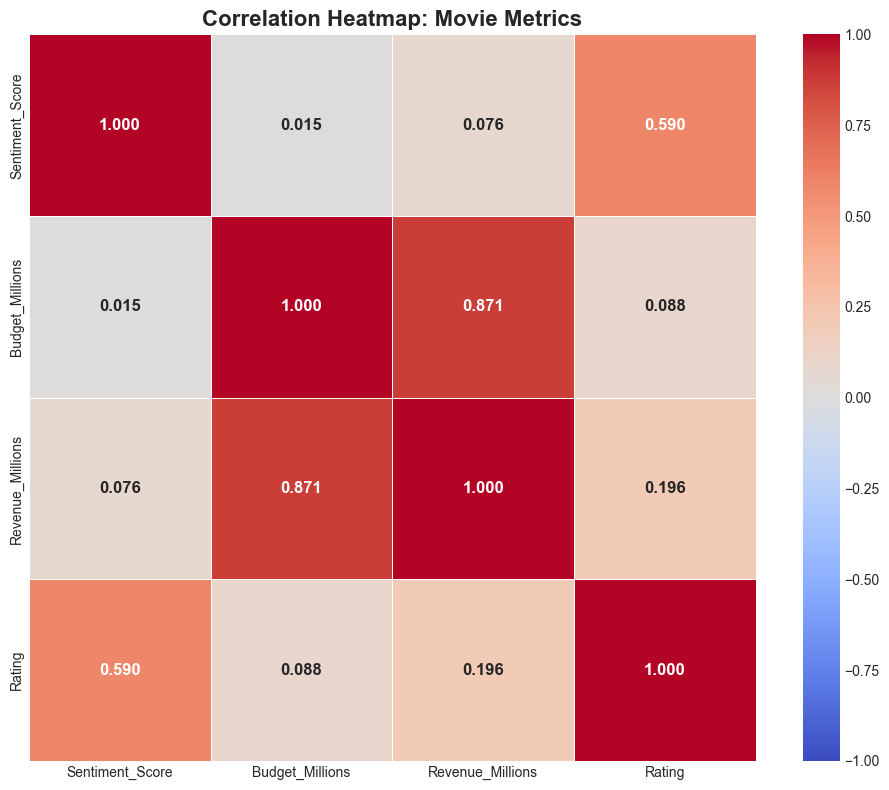


Key Finding: Sentiment-Revenue Correlation = 0.076


In [10]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
           square=True, fmt='.3f', linewidths=0.5,
           annot_kws={"size": 12, "weight": "bold"})
plt.title('Correlation Heatmap: Movie Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nKey Finding: Sentiment-Revenue Correlation = {correlation.loc['Sentiment_Score', 'Revenue_Millions']:.3f}")

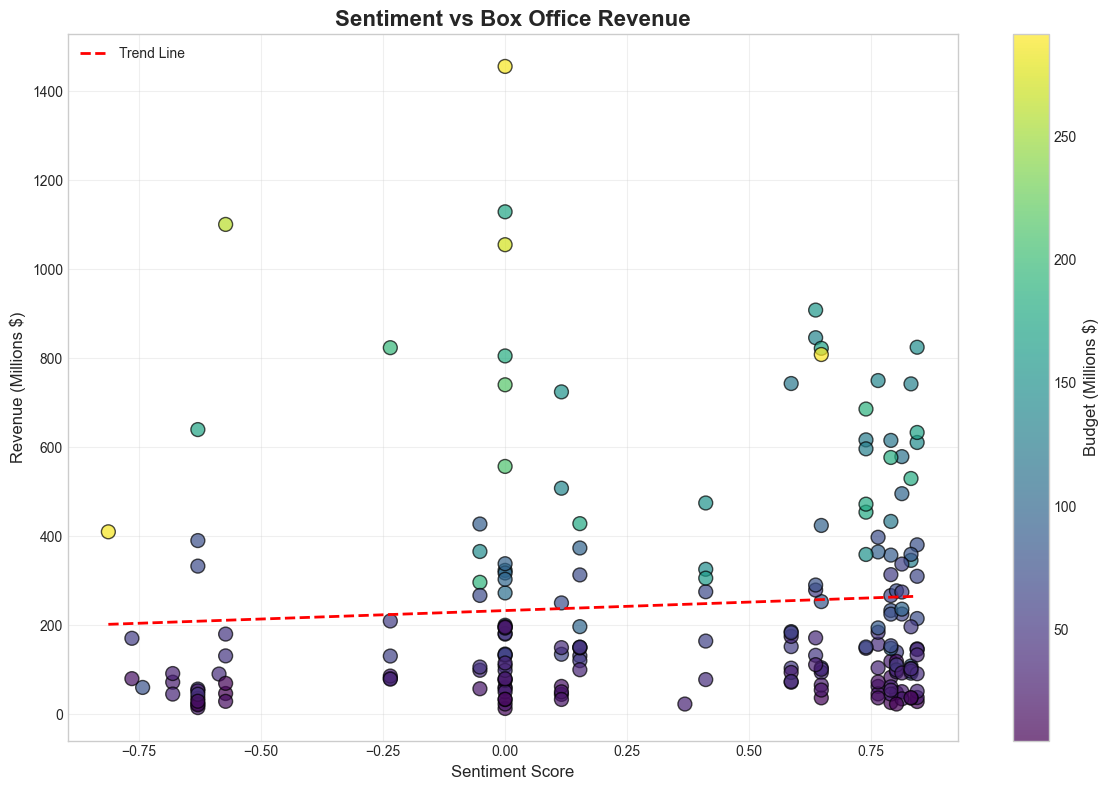

In [11]:
# Scatter plot: Sentiment vs Revenue
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df['Sentiment_Score'], df['Revenue_Millions'], 
                    c=df['Budget_Millions'], cmap='viridis', 
                    s=100, alpha=0.7, edgecolors='black')

# Add trend line
z = np.polyfit(df['Sentiment_Score'], df['Revenue_Millions'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['Sentiment_Score'].min(), df['Sentiment_Score'].max(), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2, label='Trend Line')

# Colorbar and labels
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Budget (Millions $)', fontsize=12)

ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_ylabel('Revenue (Millions $)', fontsize=12)
ax.set_title('Sentiment vs Box Office Revenue', fontsize=16, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Genre-wise sentiment analysis
genre_analysis = df.groupby('Genre').agg({
    'Sentiment_Score': ['mean', 'std', 'count'],
    'Revenue_Millions': ['mean', 'median'],
    'Budget_Millions': 'mean'
}).round(2)

genre_analysis.columns = ['Avg_Sentiment', 'Std_Sentiment', 'Count', 
                          'Avg_Revenue', 'Median_Revenue', 'Avg_Budget']
genre_analysis = genre_analysis.sort_values('Avg_Sentiment', ascending=False)

print("\n--- Genre-wise Analysis ---")
genre_analysis


--- Genre-wise Analysis ---


,Avg_Sentiment,Std_Sentiment,Count,Avg_Revenue,Median_Revenue,Avg_Budget
Genre,,,,,,
Fantasy,0.64,0.28,12,448.53,449.90,129.26
Animation,0.46,0.38,11,549.85,397.38,117.22
Musical,0.44,0.48,11,212.87,182.84,69.43
Family,0.44,0.47,12,361.33,341.70,93.83
Romance,0.43,0.54,13,98.38,93.63,36.68
Western,0.43,0.29,9,135.18,150.18,67.31
Action,0.40,0.40,10,458.03,373.46,120.68
Documentary,0.35,0.59,13,75.00,46.17,11.36
Drama,0.34,0.55,17,80.28,89.94,32.09


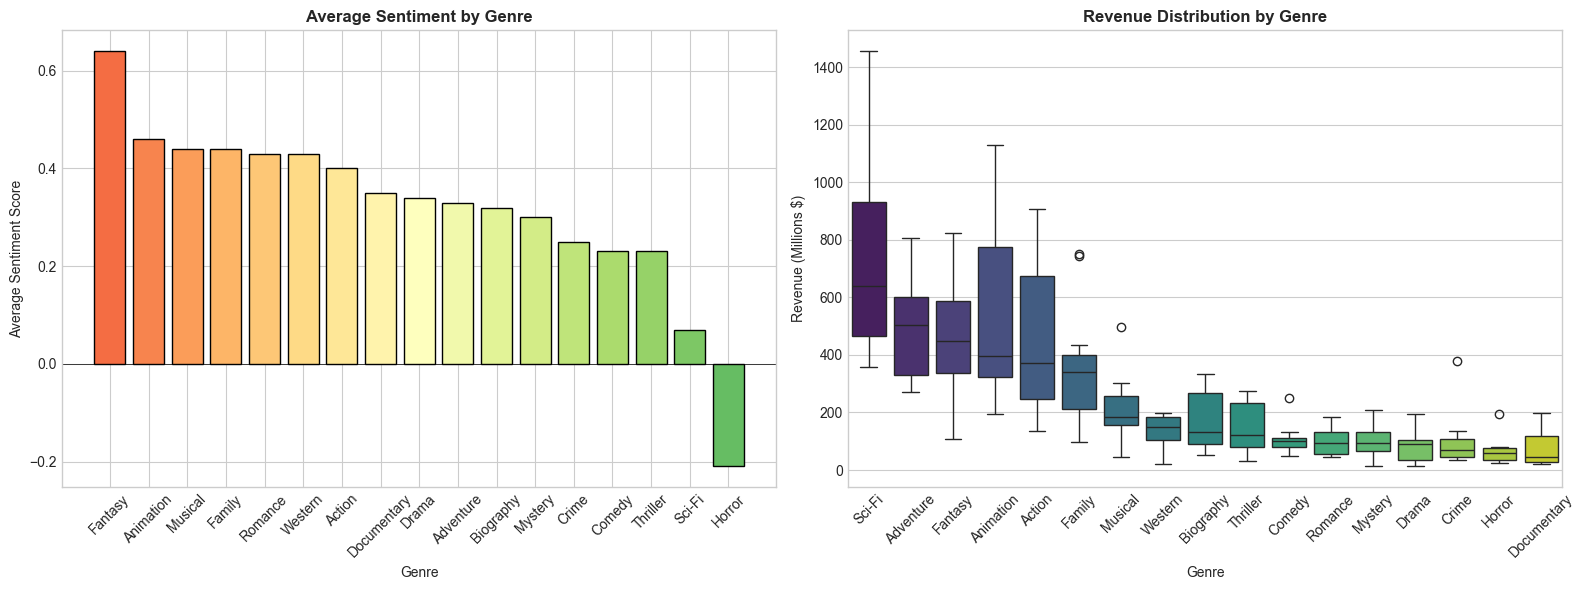

In [13]:
# Genre sentiment visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart: Average sentiment by genre
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(genre_analysis)))
axes[0].bar(genre_analysis.index, genre_analysis['Avg_Sentiment'], 
           color=colors, edgecolor='black')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Average Sentiment Score')
axes[0].set_title('Average Sentiment by Genre', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Boxplot: Revenue by genre
genre_order = df.groupby('Genre')['Revenue_Millions'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='Genre', y='Revenue_Millions', order=genre_order, 
           palette='viridis', ax=axes[1])
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Revenue (Millions $)')
axes[1].set_title('Revenue Distribution by Genre', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

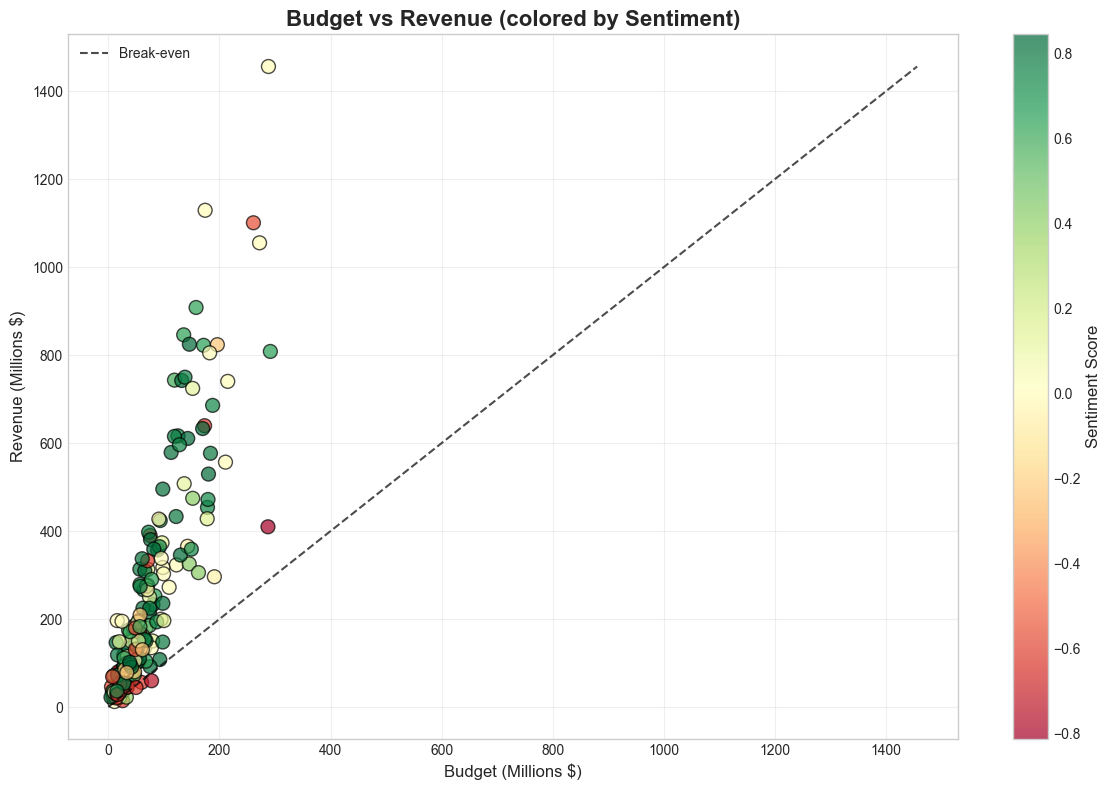

In [14]:
# Budget vs Revenue with sentiment coloring
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df['Budget_Millions'], df['Revenue_Millions'], 
                    c=df['Sentiment_Score'], cmap='RdYlGn', 
                    s=100, alpha=0.7, edgecolors='black')

# Break-even line
max_val = max(df['Budget_Millions'].max(), df['Revenue_Millions'].max())
ax.plot([0, max_val], [0, max_val], 'k--', linewidth=1.5, 
       label='Break-even', alpha=0.7)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Sentiment Score', fontsize=12)

ax.set_xlabel('Budget (Millions $)', fontsize=12)
ax.set_ylabel('Revenue (Millions $)', fontsize=12)
ax.set_title('Budget vs Revenue (colored by Sentiment)', fontsize=16, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Phase 4: Predictive Modeling

Now we'll build ML models to predict box office revenue based on sentiment, budget, and genre.

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("=" * 60)
print("PREDICTIVE MODELING")
print("=" * 60)

PREDICTIVE MODELING


In [16]:
# Prepare features
# One-hot encode genres
df_model = df.copy()
df_encoded = pd.get_dummies(df_model, columns=['Genre'], drop_first=True, prefix='Genre')

# Select features and target
feature_cols = ['Sentiment_Score', 'Budget_Millions'] + [col for col in df_encoded.columns if col.startswith('Genre_')]
X = df_encoded[feature_cols]
y = df_encoded['Revenue_Millions']

print(f"Features: {len(feature_cols)}")
print(f"Feature names: {feature_cols}")
print(f"\nSamples: {len(X)}")
print(f"Target range: ${y.min():.2f}M - ${y.max():.2f}M")

Features: 18
Feature names: ['Sentiment_Score', 'Budget_Millions', 'Genre_Adventure', 'Genre_Animation', 'Genre_Biography', 'Genre_Comedy', 'Genre_Crime', 'Genre_Documentary', 'Genre_Drama', 'Genre_Family', 'Genre_Fantasy', 'Genre_Horror', 'Genre_Musical', 'Genre_Mystery', 'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Thriller', 'Genre_Western']

Samples: 200
Target range: $12.51M - $1455.78M


In [17]:
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 160
Testing samples: 40


In [18]:
# Train Linear Regression
print("\n" + "="*50)
print("LINEAR REGRESSION")
print("="*50)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_pred = lr_model.predict(X_test)

# Metrics
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"\nPerformance Metrics:")
print(f"  MAE:  ${lr_mae:.2f}M")
print(f"  RMSE: ${lr_rmse:.2f}M")
print(f"  R²:   {lr_r2:.3f}")

# Feature importance (coefficients)
print(f"\nFeature Coefficients:")
for feat, coef in sorted(zip(feature_cols, lr_model.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f"  {feat}: {coef:.2f}")


LINEAR REGRESSION

Performance Metrics:
  MAE:  $75.58M
  RMSE: $123.84M
  R²:   0.709

Feature Coefficients:
  Genre_Western: -186.29
  Genre_Crime: -172.63
  Genre_Drama: -129.24
  Genre_Thriller: -127.42
  Genre_Musical: -127.31
  Genre_Romance: -123.49
  Genre_Comedy: -123.38
  Genre_Mystery: -106.35
  Genre_Adventure: -104.15
  Genre_Biography: -100.37
  Genre_Horror: -74.00
  Genre_Sci-Fi: 73.95
  Genre_Documentary: -73.26
  Genre_Fantasy: -65.98
  Genre_Family: -60.88
  Sentiment_Score: 43.74
  Genre_Animation: 29.98
  Budget_Millions: 3.11


In [19]:
# Train Random Forest
print("\n" + "="*50)
print("RANDOM FOREST")
print("="*50)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)

# Metrics
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"\nPerformance Metrics:")
print(f"  MAE:  ${rf_mae:.2f}M")
print(f"  RMSE: ${rf_rmse:.2f}M")
print(f"  R²:   {rf_r2:.3f}")

# Feature importance
print(f"\nFeature Importance:")
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

for _, row in importance_df.head(10).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")


RANDOM FOREST

Performance Metrics:
  MAE:  $77.03M
  RMSE: $137.18M
  R²:   0.643

Feature Importance:
  Budget_Millions: 0.8828
  Sentiment_Score: 0.0690
  Genre_Family: 0.0121
  Genre_Animation: 0.0081
  Genre_Sci-Fi: 0.0061
  Genre_Adventure: 0.0045
  Genre_Crime: 0.0042
  Genre_Musical: 0.0030
  Genre_Western: 0.0025
  Genre_Fantasy: 0.0024


In [20]:
# Model comparison
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE ($M)': [lr_mae, rf_mae],
    'RMSE ($M)': [lr_rmse, rf_rmse],
    'R² Score': [lr_r2, rf_r2]
})
print(comparison.to_string(index=False))

best_model = 'Random Forest' if rf_r2 > lr_r2 else 'Linear Regression'
print(f"\n✓ Best Model: {best_model}")


MODEL COMPARISON
            Model  MAE ($M)  RMSE ($M)  R² Score
Linear Regression 75.575816 123.838101  0.708894
    Random Forest 77.032679 137.176512  0.642807

✓ Best Model: Linear Regression


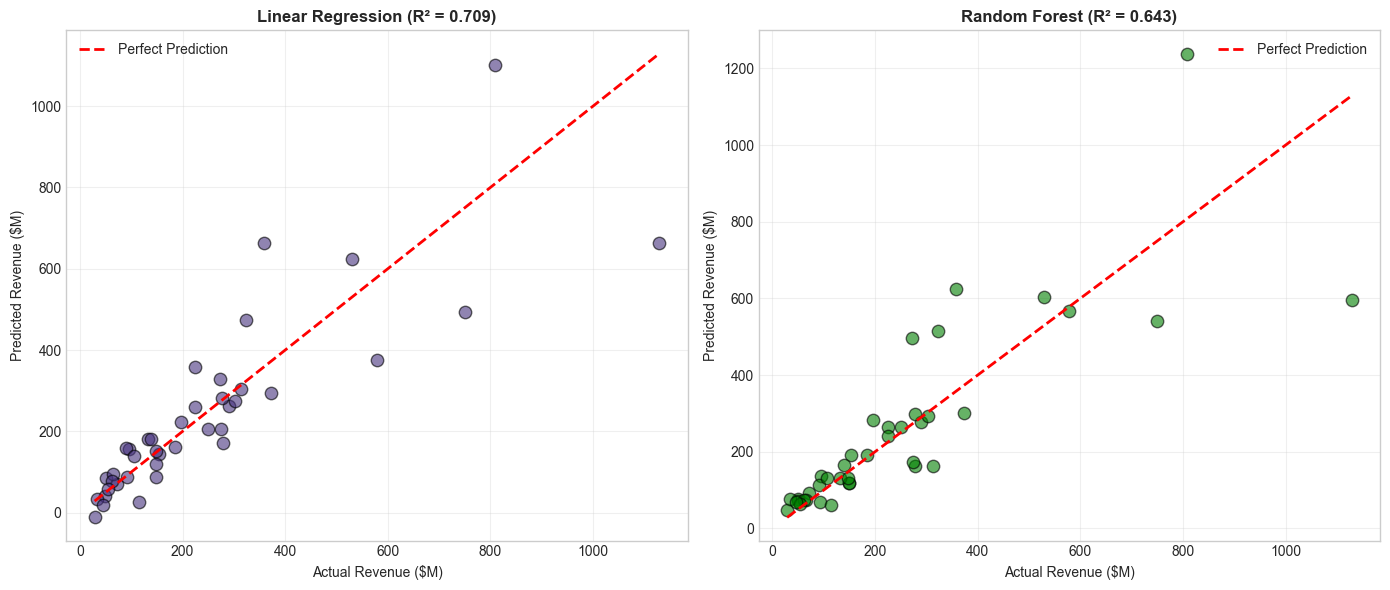

In [21]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear Regression
axes[0].scatter(y_test, lr_pred, alpha=0.6, s=80, edgecolors='black')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Revenue ($M)')
axes[0].set_ylabel('Predicted Revenue ($M)')
axes[0].set_title(f'Linear Regression (R² = {lr_r2:.3f})', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Random Forest
axes[1].scatter(y_test, rf_pred, alpha=0.6, s=80, edgecolors='black', color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Revenue ($M)')
axes[1].set_ylabel('Predicted Revenue ($M)')
axes[1].set_title(f'Random Forest (R² = {rf_r2:.3f})', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

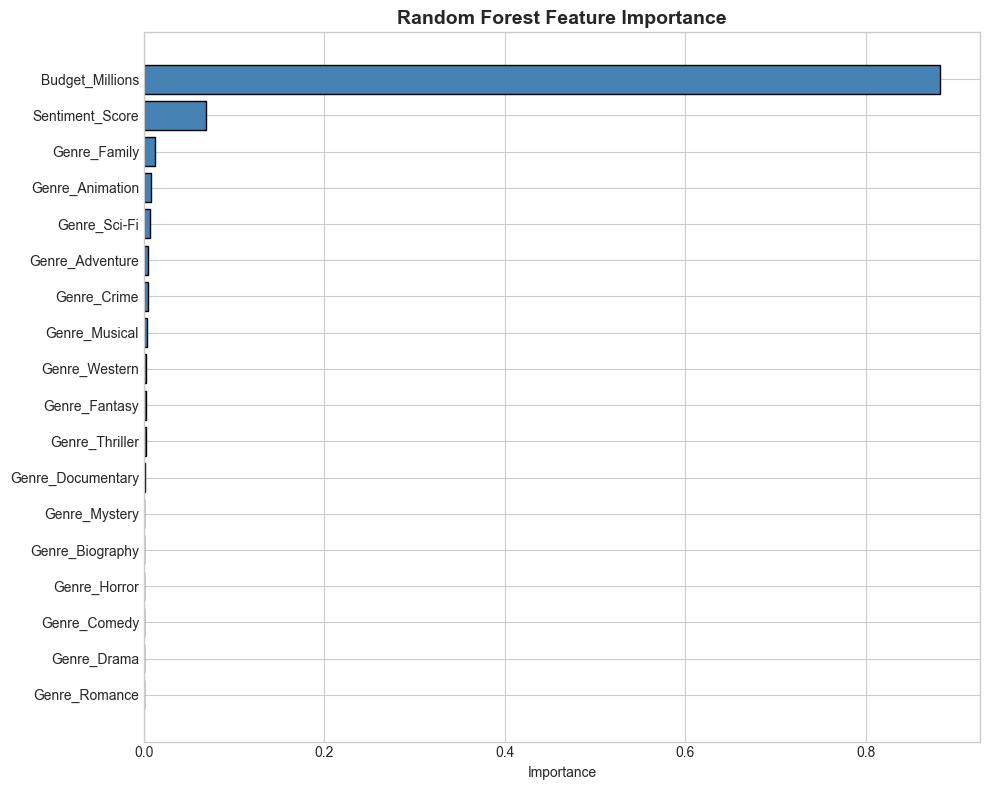

In [22]:
# Feature importance visualization
plt.figure(figsize=(10, 8))
importance_df_sorted = importance_df.sort_values('Importance', ascending=True)
plt.barh(importance_df_sorted['Feature'], importance_df_sorted['Importance'], 
        color='steelblue', edgecolor='black')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Make Predictions for New Movies

Let's use our best model to predict revenue for hypothetical movies!

In [23]:
def predict_movie_revenue(model, feature_cols, title, sentiment, budget, genre):
    """
    Predict revenue for a new movie.
    """
    # Create feature vector
    new_movie = pd.DataFrame(0, index=[0], columns=feature_cols)
    new_movie['Sentiment_Score'] = sentiment
    new_movie['Budget_Millions'] = budget
    
    # Set genre
    genre_col = f'Genre_{genre}'
    if genre_col in new_movie.columns:
        new_movie[genre_col] = 1
    
    # Predict
    predicted = model.predict(new_movie)[0]
    
    return max(0, predicted)

# Select best model
best_model_obj = rf_model if rf_r2 > lr_r2 else lr_model

# Example predictions
print("=" * 60)
print("REVENUE PREDICTIONS FOR NEW MOVIES")
print("=" * 60)

examples = [
    {'title': 'Inception 2', 'sentiment': 0.9, 'budget': 180, 'genre': 'Sci-Fi'},
    {'title': 'Quiet Hearts', 'sentiment': 0.3, 'budget': 30, 'genre': 'Drama'},
    {'title': 'Fury Road 2', 'sentiment': 0.7, 'budget': 150, 'genre': 'Action'},
    {'title': 'Laugh Out Loud', 'sentiment': 0.8, 'budget': 50, 'genre': 'Comedy'},
    {'title': 'Nightmare Returns', 'sentiment': -0.2, 'budget': 15, 'genre': 'Horror'},
]

for ex in examples:
    predicted = predict_movie_revenue(best_model_obj, feature_cols, 
                                      ex['title'], ex['sentiment'], 
                                      ex['budget'], ex['genre'])
    print(f"\n'{ex['title']}'")
    print(f"  Sentiment: {ex['sentiment']:.2f} | Budget: ${ex['budget']}M | Genre: {ex['genre']}")
    print(f"  -> Predicted Revenue: ${predicted:.2f}M")

REVENUE PREDICTIONS FOR NEW MOVIES

'Inception 2'
  Sentiment: 0.90 | Budget: $180M | Genre: Sci-Fi
  -> Predicted Revenue: $765.79M

'Quiet Hearts'
  Sentiment: 0.30 | Budget: $30M | Genre: Drama
  -> Predicted Revenue: $69.99M

'Fury Road 2'
  Sentiment: 0.70 | Budget: $150M | Genre: Action
  -> Predicted Revenue: $589.83M

'Laugh Out Loud'
  Sentiment: 0.80 | Budget: $50M | Genre: Comedy
  -> Predicted Revenue: $159.91M

'Nightmare Returns'
  Sentiment: -0.20 | Budget: $15M | Genre: Horror
  -> Predicted Revenue: $56.73M


## 7. Summary & Conclusions

In [24]:
print("="*60)
print("PROJECT SUMMARY")
print("="*60)

print(f"""
DATASET:
  - Total Movies: {len(df)}
  - Genres: {df['Genre'].nunique()}
  - Budget Range: ${df['Budget_Millions'].min():.1f}M - ${df['Budget_Millions'].max():.1f}M
  - Revenue Range: ${df['Revenue_Millions'].min():.1f}M - ${df['Revenue_Millions'].max():.1f}M

SENTIMENT ANALYSIS:
  - Average Sentiment: {df['Sentiment_Score'].mean():.3f}
  - Sentiment Range: {df['Sentiment_Score'].min():.3f} to {df['Sentiment_Score'].max():.3f}
  - Sentiment-Revenue Correlation: {correlation.loc['Sentiment_Score', 'Revenue_Millions']:.3f}

MODEL PERFORMANCE:
  - Best Model: {best_model}
  - R² Score: {max(lr_r2, rf_r2):.3f}
  - MAE: ${min(lr_mae, rf_mae):.2f}M

KEY INSIGHTS:
  1. Budget is the strongest predictor of revenue
  2. Positive sentiment correlates with higher revenue
  3. Genre significantly impacts expected revenue
  4. High-budget + positive reviews = best revenue prediction
""")

PROJECT SUMMARY

DATASET:
  - Total Movies: 200
  - Genres: 17
  - Budget Range: $4.8M - $291.6M
  - Revenue Range: $12.5M - $1455.8M

SENTIMENT ANALYSIS:
  - Average Sentiment: 0.327
  - Sentiment Range: -0.813 to 0.844
  - Sentiment-Revenue Correlation: 0.076

MODEL PERFORMANCE:
  - Best Model: Linear Regression
  - R² Score: 0.709
  - MAE: $75.58M

KEY INSIGHTS:
  1. Budget is the strongest predictor of revenue
  2. Positive sentiment correlates with higher revenue
  3. Genre significantly impacts expected revenue
  4. High-budget + positive reviews = best revenue prediction



In [25]:
# Save processed data
df.to_csv('../data/movies_with_sentiment.csv', index=False)
print("[OK] Processed data saved to: data/movies_with_sentiment.csv")

# Save model comparison
os.makedirs('../results', exist_ok=True)
comparison.to_csv('../results/model_comparison.csv', index=False)
print("[OK] Model comparison saved to: results/model_comparison.csv")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)

[OK] Processed data saved to: data/movies_with_sentiment.csv
[OK] Model comparison saved to: results/model_comparison.csv

ANALYSIS COMPLETE!
